In [1]:
import casatasks as ctask
import casatools as ctool
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from spectral_cube import SpectralCube as sc
import astropy.units as U
import astropy.constants as const
import warnings
warnings.filterwarnings('ignore')

In [2]:
path="G2-data/ATCA/"
fullcube=path+"smallcube.fits"
cubeim=path+'j1250-atca.fits'
momimage=path+'j1250-atca'+'.mom0'

ctask.imsubimage(imagename=fullcube,outfile=path+'j1250-atca',region='centerbox [[138pix, 119pix], [100pix, 100pix]]',overwrite=True)
ctask.exportfits(imagename=path+'j1250-atca', fitsimage=cubeim, overwrite=True)

sccube=sc.read(cubeim)
velcube=sccube.with_spectral_unit(unit=U.km/U.s, velocity_convention='optical',rest_value=1.420405745510*U.GHz) #Converting cube to vel scale
velcube_chan=velcube.spectral_slab(7670*U.km/U.s,7825*U.km/U.s) #channel cuts 

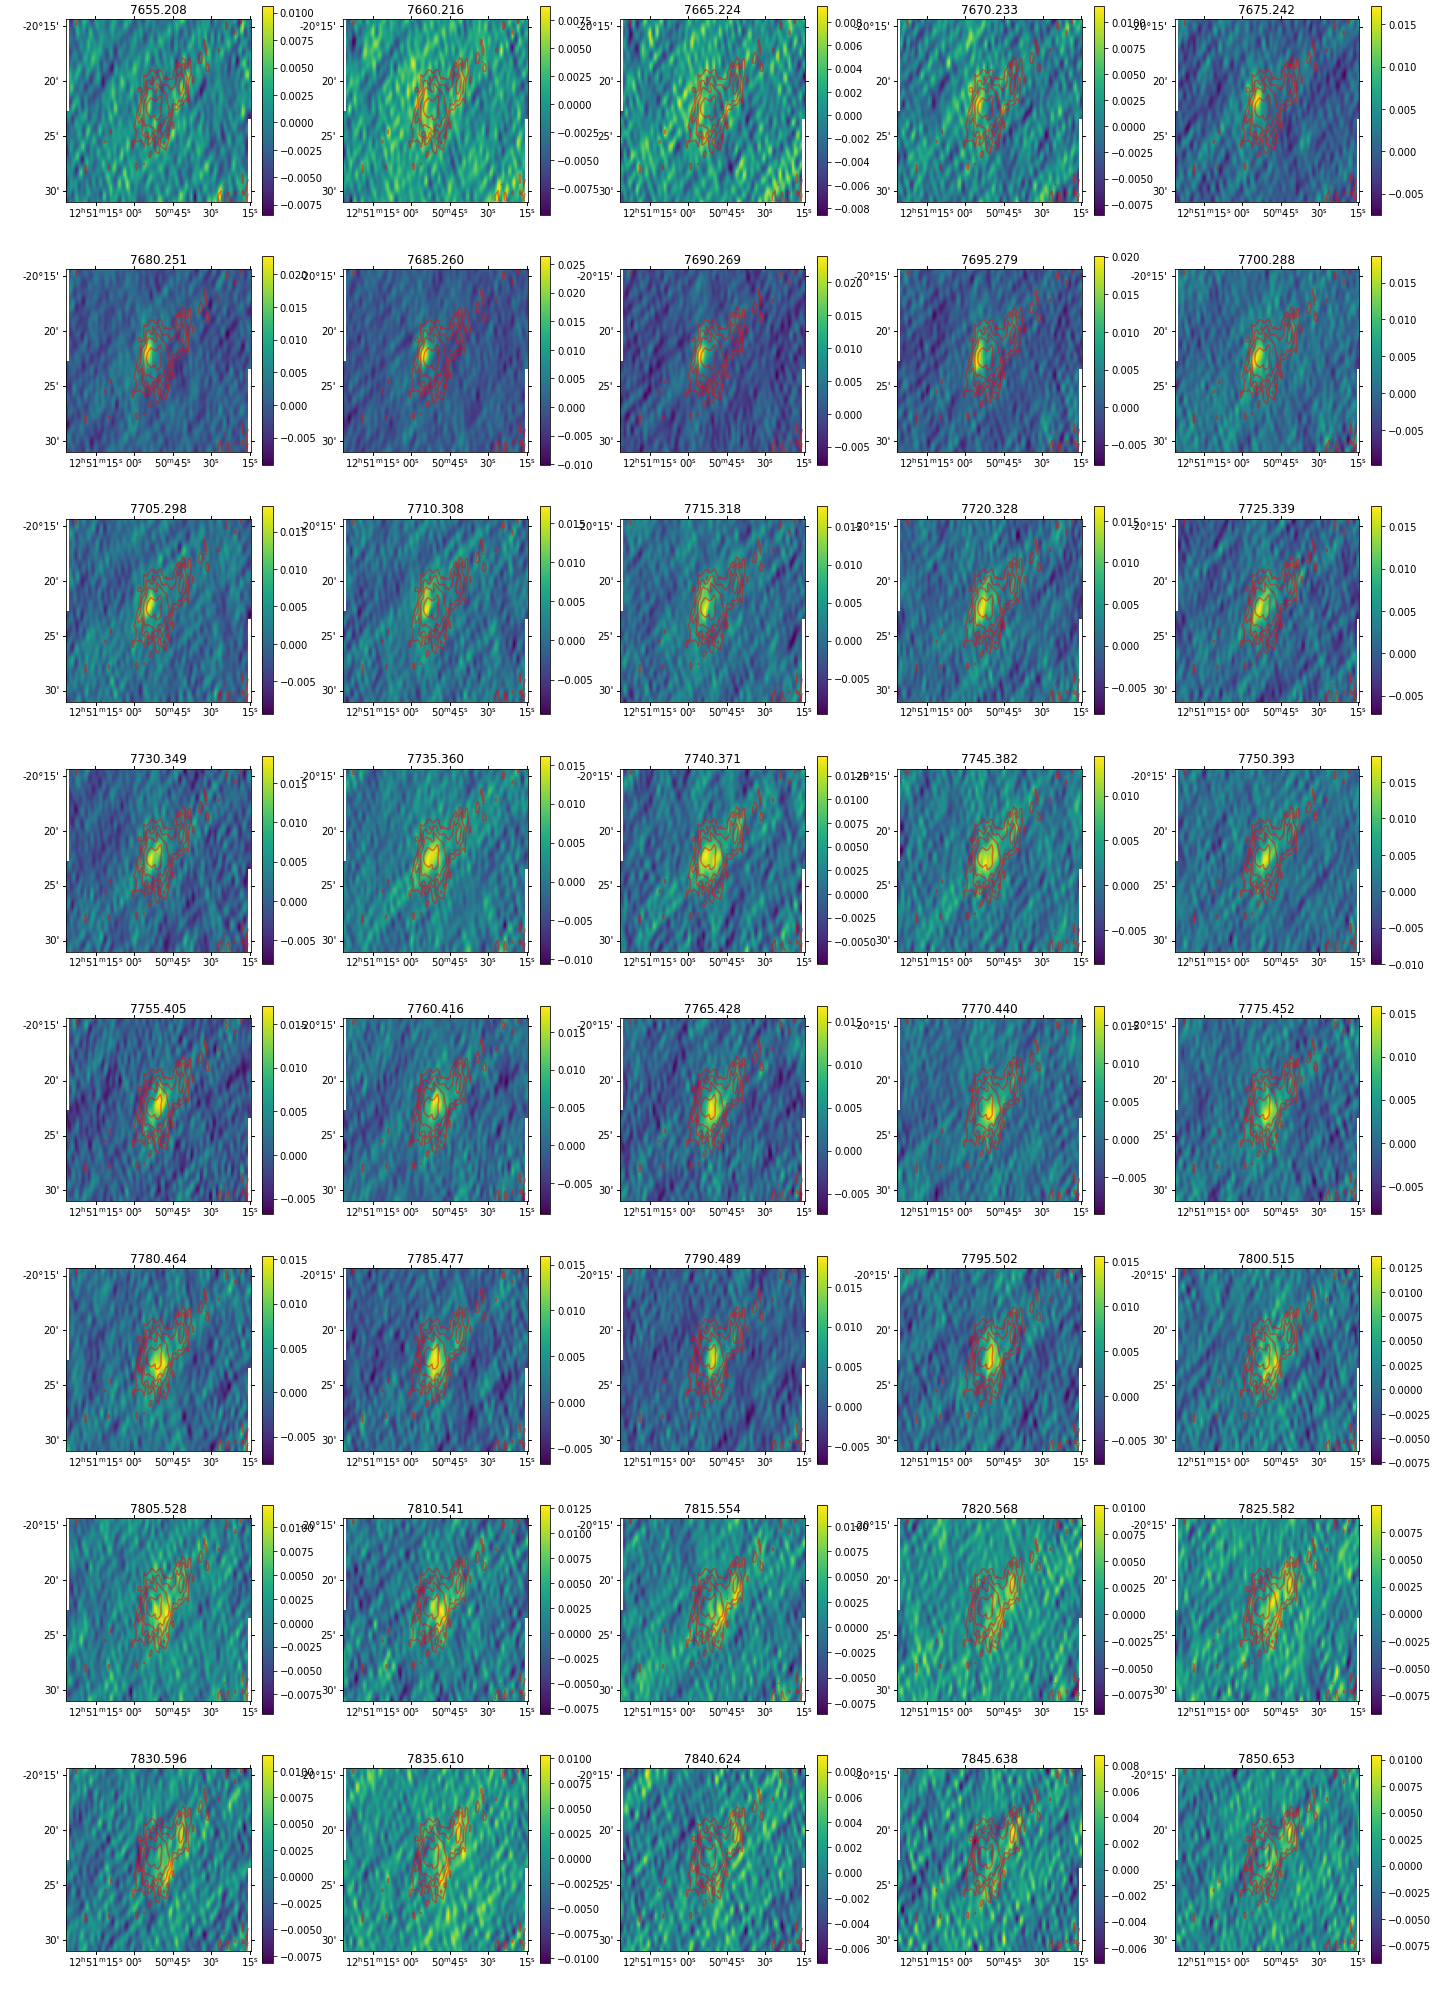

In [3]:
levels =[0.4, 0.57, 0.8, 1.27]
momconto=fits.getdata(momimage+'.fits',interpolation='hanning')[0,0,:,:]
vel_rad=velcube.spectral_axis

chan = np.arange(51,91,1)
plt.figure(figsize=(24,36))
for ii, i in enumerate(chan):
    ax = plt.subplot(8,5,ii+1, projection=sccube[0].wcs)
    im=ax.imshow(fits.getdata(cubeim)[0,i,:,:])
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    plt.colorbar(im)
    ax.set_title('%.3f'%(vel_rad[i].value))
    ax.contour(momconto, colors=['red'], alpha=0.5, levels=levels)

#plot_channel_maps - Alternative

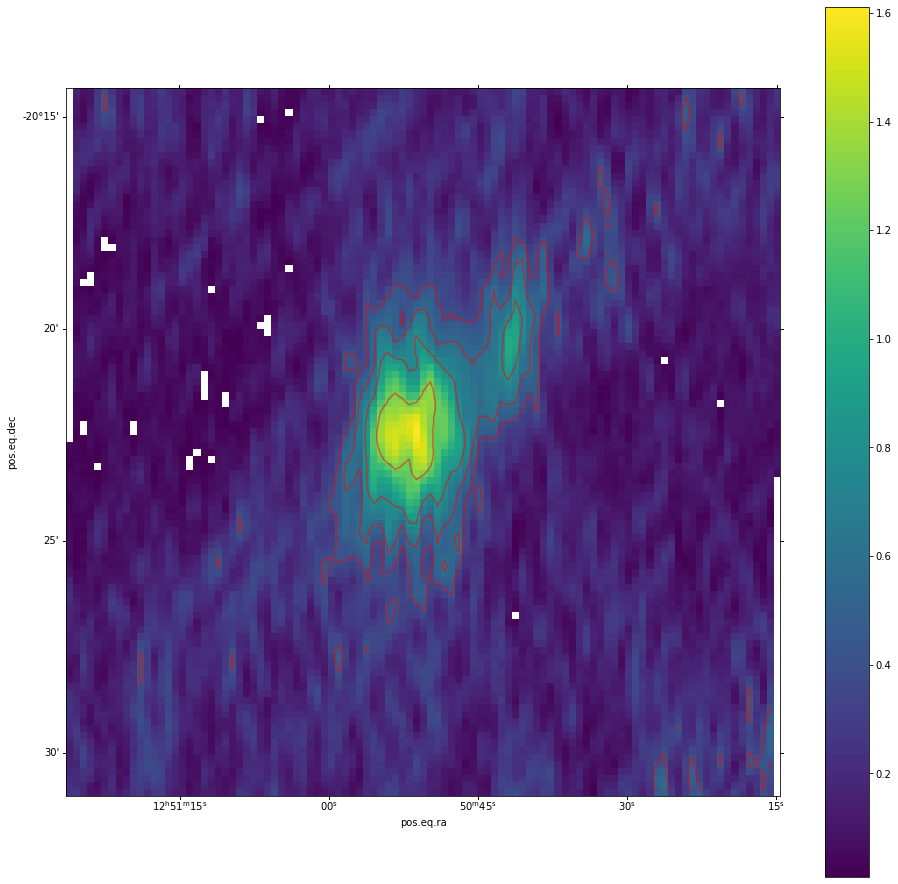

In [4]:
mask= (velcube_chan > 0.005 *U.Jy/U.beam) & (velcube_chan < 17 *U.Jy/U.beam)
vel_masked=velcube_chan.with_mask(mask)
mom0_new=vel_masked.moment(order=0,axis=0,how='auto') #mom0

#Moment Map with immoments
#ctask.immoments(imagename=path+'j1250-atca',moments=[0],axis='spectral',chans='51~91',outfile=momimage,includepix=[0.002,17])
#ctask.exportfits(imagename=momimage, fitsimage=momimage+'.fits', overwrite=True)

plt.figure(figsize=(16,16))
mo=plt.subplot(1,1,1,projection=velcube[0].wcs)
mom0=mo.imshow(fits.getdata(momimage+'.fits',interpolation='hanning')[0,0,:,:])
plt.colorbar(mom0,ax=mo)

# Overplot contours
#levels = [3.5e19, 7e19, 20e19, 30e19, 40e19, 45e19]  # Define contour levels to use
levels =[0.4, 0.57, 0.8, 1.27]
mo.contour(fits.getdata(momimage+'.fits',interpolation='hanning')[0,0,:,:], colors=['red'], alpha=0.5, levels=levels)


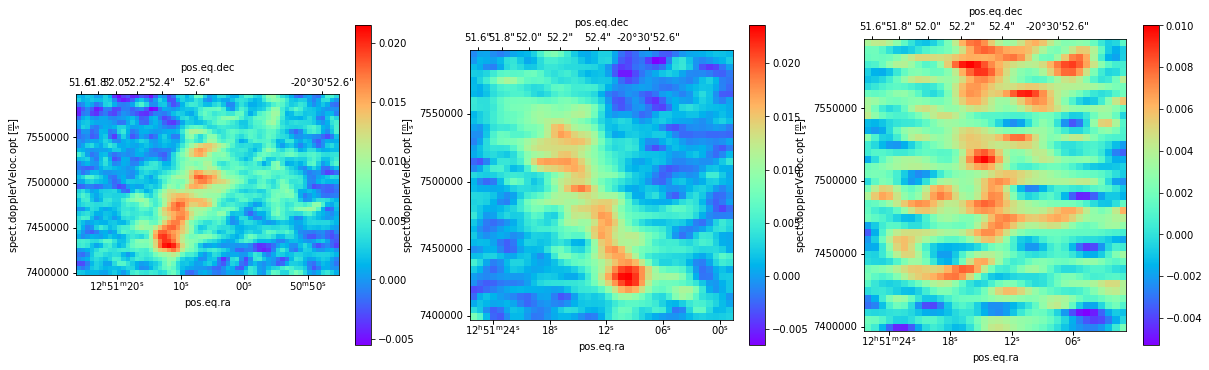

In [5]:
#PV Slice extractor and SpectralCube

from pvextractor import extract_pv_slice
from pvextractor.geometry import Path

fit=velcube

g2 = [(28,37),(74,73)]
s1 = [(58,36),(35,68)]
s2 = [(59,82),(68,47)]
xyg2 = Path(g2)
xys1= Path(s1)
xys2 = Path(s2)
pvg2 = extract_pv_slice(fit[51:91,:,:], xyg2)
pvs1 = extract_pv_slice(fit[51:91,:,:], xys1)
pvs2 = extract_pv_slice(fit[51:91,:,:], xys2)

#pv.writeto(path+'my_slice.fits',) 

plt.figure(figsize=(20,20))
ag2 = plt.subplot(3,3,1,projection=fit.wcs,slices=('x',0,'y'))
pvg2im=ag2.imshow(pvg2.data, cmap='rainbow')
plt.colorbar(pvg2im)

as1 = plt.subplot(3,3,2,projection=fit.wcs, slices=('x',0,'y'))
pvs1im=as1.imshow(pvs1.data, cmap='rainbow')
plt.colorbar(pvs1im)
as2 = plt.subplot(3,3,3,projection=fit.wcs, slices=('x',0,'y'))
pvs2im=as2.imshow(pvs2.data, cmap='rainbow')
plt.colorbar(pvs2im)


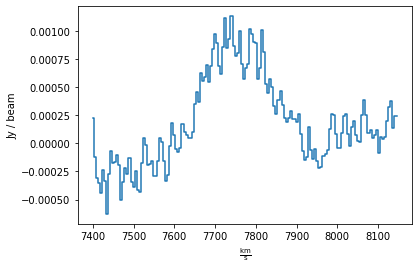

In [6]:
#Extract Spectrum

spec = fit.mean(axis=(1,2))
spec.quicklook()

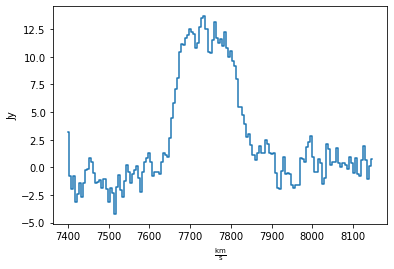

In [7]:
## Masked Spectrum Extraction -G2S1
import regions

crtf_g2s1 = "ellipse[[12h50m53.33284s, -20.22.54.8942],[4.7arcmin, 2.2arcmin],0deg] coord=J2000"
cubeg2s1 = fit.subcube_from_crtfregion(crtf_g2s1)

#cubeg2s1[25,:,:].quicklook()
specg2s1 = cubeg2s1.mean(axis=(1, 2))* (102.96 * 30.86)* U.beam
specg2s1.quicklook()

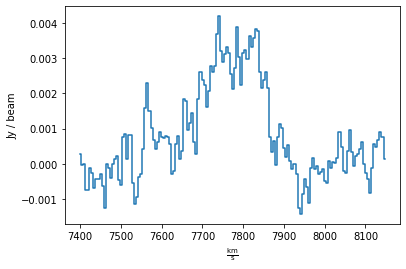

In [8]:
## Masked Spectrum Extraction -G1S2
crtf_g2s2 = "ellipse[[12h50m41.24756s, -020.20.04.5828], [150arcsec, 70arcsec], 0deg] coord=J2000"
cubeg2s2 = fit.subcube_from_crtfregion(crtf_g2s2)
#cubeg2s2[25,:,:].quicklook()
specg2s2 = cubeg2s2.mean(axis=(1, 2))
specg2s2.quicklook()

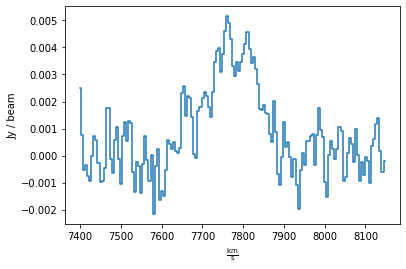

In [9]:
## Masked Spectrum Extraction -G2-bridge

bridgeg2 = "ellipse[[12h50m45.06110s, -020.21.22.2589], [116arcsec, 23arcsec], 17deg] coord=J2000"
cubeg2b = fit.subcube_from_crtfregion(bridgeg2)
#cubeg1b[25,:,:].quicklook()
specg2b = cubeg2b.mean(axis=(1, 2)) 
specg2b.quicklook()

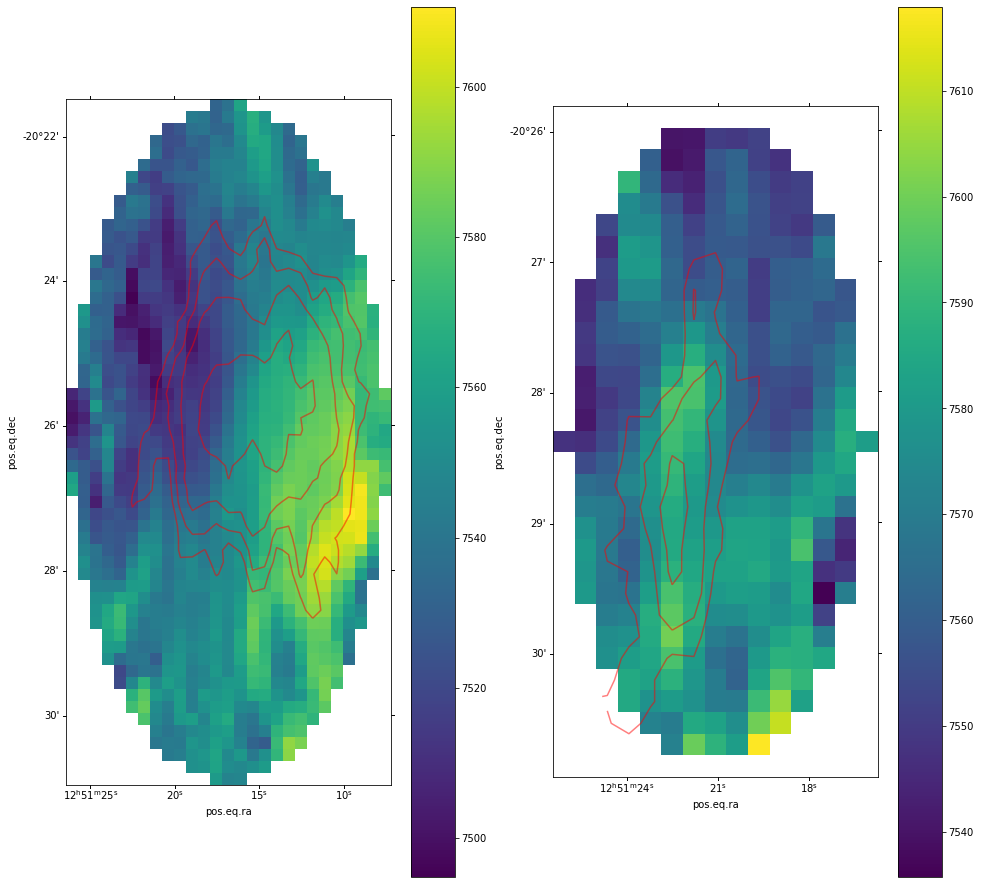

In [31]:
#Moment 1 for S1 and S2 usimg casa - Threshold at 2mJy

#ctask.immoments(imagename=cubeim,moments=[1],axis='spectral',chans='51~91',outfile=path+'g2s1-mom1',region='ellipse[[12h50m53.33284s, -20d22m54.8942s],[4.7arcmin, 2.2arcmin],0deg]',includepix = [0.002,30])
#ctask.exportfits(imagename=path+'g2s1-mom1', fitsimage=path+'g2s1m1.fits', overwrite=True)
mom0s1=g2s1_masked.moment(order=0)
mom0s2=g2s2_masked.moment(order=0)

plt.figure(figsize=(16,16))
g2s1m1=plt.subplot(1,2,1, projection=fit.wcs,slices=('x','y',0))
mom1s1plt=g2s1m1.imshow(fits.getdata(path+'g2s1m1.fits')[0,0,:,:])
plt.colorbar(mom1s1plt,ax=g2s1m1)
g2s1m1.contour(mom0s1.data, colors=['red'], alpha=0.5, levels=levels)

#ctask.immoments(imagename=cubeim,moments=[1],axis='spectral',chans='51~91',outfile=path+'g2s2-mom1',region='ellipse[[12h50m41.24756s, -020d20m04.5828], [150arcsec, 70arcsec], 0deg]',includepix = [0.002,30])
#ctask.exportfits(imagename=path+'g2s2-mom1', fitsimage=path+'g2s2m1.fits', overwrite=True)

g2s2m1=plt.subplot(1,2,2, projection=fit.wcs,slices=('x','y',0))
mom1s2plt=g2s2m1.imshow(fits.getdata(path+'g2s2m1.fits')[0,0,:,:])
plt.colorbar(mom1s2plt,ax=g2s2m1)
g2s2m1.contour(mom0s2.data, colors=['red'], alpha=0.5, levels=levels)


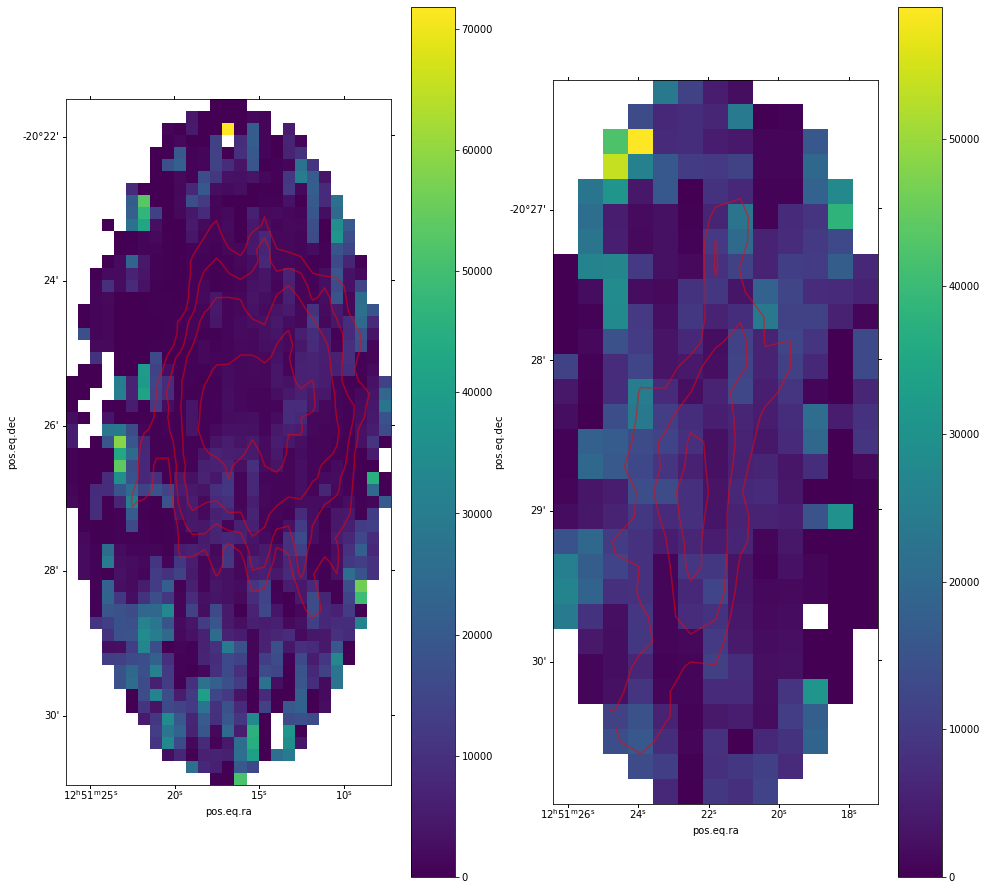

In [30]:
mask= (cubeg2s1 > 0.005 *U.Jy/U.beam) & (cubeg2s1 < 17 *U.Jy/U.beam)
g2s1_masked=cubeg2s1.with_mask(mask)
mom2s1=g2s1_masked.moment(order=2)

plt.figure(figsize=(16,16))
g2s1m2=plt.subplot(1,2,1, projection=fit.wcs,slices=('x','y',0))
mom2s1plt=g2s1m2.imshow(mom2s1.data)
plt.colorbar(mom2s1plt,ax=g2s1m2)

g2s1m2.contour(mom0s1.data, colors=['red'], alpha=0.5, levels=levels)

mask= (cubeg2s2 > 0.005 *U.Jy/U.beam) & (cubeg2s2 < 17 *U.Jy/U.beam)
g2s2_masked=cubeg2s2.with_mask(mask)
mom2s2=g2s2_masked.moment(order=2)

g2s2m2=plt.subplot(1,2,2, projection=fit.wcs,slices=('x','y',0))
mom2s2plt=g2s2m2.imshow(mom2s2.data)
plt.colorbar(mom2s2plt,ax=g2s2m2)
g2s2m2.contour(mom0s2.data, colors=['red'], alpha=0.5, levels=levels)


In [ ]:
# NHI attempts
'''
newcube=vel_masked.with_spectral_unit(unit=U.Hz)

lam, dec, ra = newcube.world[:]
vel, dec, ra = vel_masked.world[:]
S_nu= newcube.unmasked_data[:]

beam= np.pi * (102.96 * 30.86)* U.beam / 4 * np.log(2)

Tb= 1.36E-3 * lam**2 * S_nu * U.K/ (102.96 * 30.86) * U.beam / U.Hz**2 /U.Jy
Tbcube=sc(data=Tb, wcs=newcube.wcs)
mom0_Tb=Tbcube.moment(order=0) #mom0

NHI= 1.823 * 10**18 * mom0_Tb
print(NHI)

#mom0_new.write('trymom0thresh.fits', overwrite=True)

#Convert Moment_0 to a Column Density assuming optically thin media NHI formula from Ianjamasimanana+2020 
#NHI = mom0_new * (1.823 * 10**18 * 6.07**5 )/ (102.96 * 30.86) * U.beam / (U.cm * U.cm) * U.s / U.K / U.km '''

In [ ]:
# Mass estimation

Sint= np.nansum(mom0_new)* (102.96 * 30.86)* U.beam
M_HI=2.36E5 * Sint * 114**2 * U.Msun / (U.Jy * U.km / U.s)
print(np.log10(M_HI.value))

#print('Problem with Mass estimation. Think its because of the unit of beam area - Scale at z= 0.026 = .53 kpc/"')
print (mom0_new.unit, ' ', Sint.unit, ' ', M_HI.unit )


#G2S1
g2s1slab= cubeg2s1.spectral_slab(7630*U.km/U.s,7860*U.km/U.s) * (102.96 * 30.86)* U.beam

mask= (g2s1slab > (0.005 * 102.96 * 30.86) *U.Jy) & (g2s1slab < (17 * 102.96 * 30.86) *U.Jy)
masked=g2s1slab.with_mask(mask)

#masked2[5,:,:].quicklook()

print(np.nansum(masked))
g2s1mom=masked.moment(order=0,axis=0,how='auto') 
Sint=np.nansum(masked) 
M_HI=2.365 *10**5 * Sint * 114**2

print(np.log10(M_HI)* U.Msun)

